In [1]:
import sys
sys.path.append("../")
from utils import transform_image_to_kspace, transform_kspace_to_image
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import pydicom

#data_path = r'C:\from SSD\fastMRI_brain_DICOM\100099070170\279.dcm'
#data_path = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM\100099070170\308.dcm'
data_path = r"C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM\300008311232\767.dcm"
#data_path = r"C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM\200082623039\829.dcm"
data = pydicom.dcmread(data_path)

image = data.pixel_array
if (np.shape(image) != (320, 320)):
    image = cv2.resize(image, (320, 320))

image = (image - np.mean(image)) / np.std(image)

kspace = transform_image_to_kspace(image)

In [2]:
# method Attila = adds Gaussian noise to image space    
def add_noise_1(kspace):    
    mag = np.random.uniform(0.1, 0.2)
    print(mag)
    img = transform_kspace_to_image(kspace)
    img = (img - np.mean(img)) / np.std(img)
    kspace = transform_image_to_kspace(img + np.random.normal(0, mag, size=np.shape(kspace)))
    return kspace

In [3]:
# method k space explorer = adds noise in decibel to k space
def add_noise_2(kspace):
    signal_to_noise = random.randint(-30, 30) #TODO: find common SNR values in literature
    print(signal_to_noise)
    mean_signal = np.mean(np.abs(kspace))
    std_noise = mean_signal / np.power(10, (signal_to_noise / 20))
    noise = std_noise * np.random.randn(*kspace.shape)
    print(noise[0])
    kspace += noise
    return kspace

In [4]:
# method self = adds Complex Gaussian noise with sd related to max pixel value
def add_noise_3(kspace):
    mag = np.random.uniform(0.002, 0.0025)
    mag_real = mag*np.max(np.real(kspace)) # doesn't work well because of outliers in kspace data
    mag_imag = mag*np.max(np.imag(kspace))
    noise = np.random.normal(0, mag_real, size=np.shape(kspace)) + 1j*np.random.normal(0, mag_imag, size=np.shape(kspace))
    kspace += noise
    return kspace

In [5]:
# method self = adds Complex Gaussian noise with predefined sd
def add_noise_4(kspace):
    mag = np.random.uniform(0.1, 0.2)
    noise = np.random.normal(0, mag, size=np.shape(kspace)) + 1j*np.random.normal(0, mag, size=np.shape(kspace))
    kspace += noise
    return kspace

(array([[  0.,   0., 320., ...,   0.,   0.,   0.],
        [  0.,   0., 320., ...,   0.,   0.,   0.],
        [  0.,   0., 320., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0., 320., ...,   0.,   0.,   0.],
        [  0.,   0., 320., ...,   0.,   0.,   0.],
        [  0.,   0., 320., ...,   0.,   0.,   0.]]),
 array([-27.51544372, -13.97573274,  -0.43602175,  13.10368924,
         26.64340022,  40.18311121,  53.7228222 ,  67.26253318,
         80.80224417,  94.34195516, 107.88166615]),
 <a list of 320 BarContainer objects>)

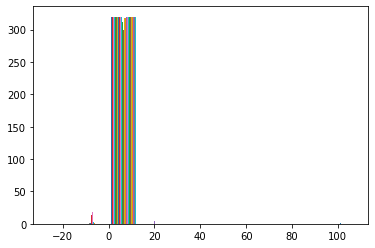

In [6]:
plt.hist(np.real(kspace))

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-31.24291439, -24.99433151, -18.74574863, -12.49716576,
         -6.24858288,   0.        ,   6.24858288,  12.49716576,
         18.74574863,  24.99433151,  31.24291439]),
 <a list of 320 BarContainer objects>)

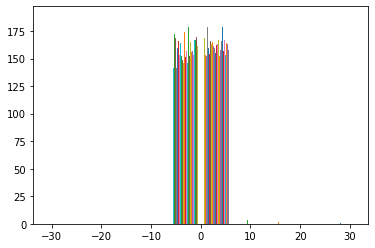

In [7]:
plt.hist(np.imag(kspace))

In [8]:
# still inside function
kspace_noise = add_noise_4(kspace)

img = transform_kspace_to_image(kspace_noise)
img = (img - np.mean(img)) / np.std(img)

(-0.5, 319.5, 319.5, -0.5)

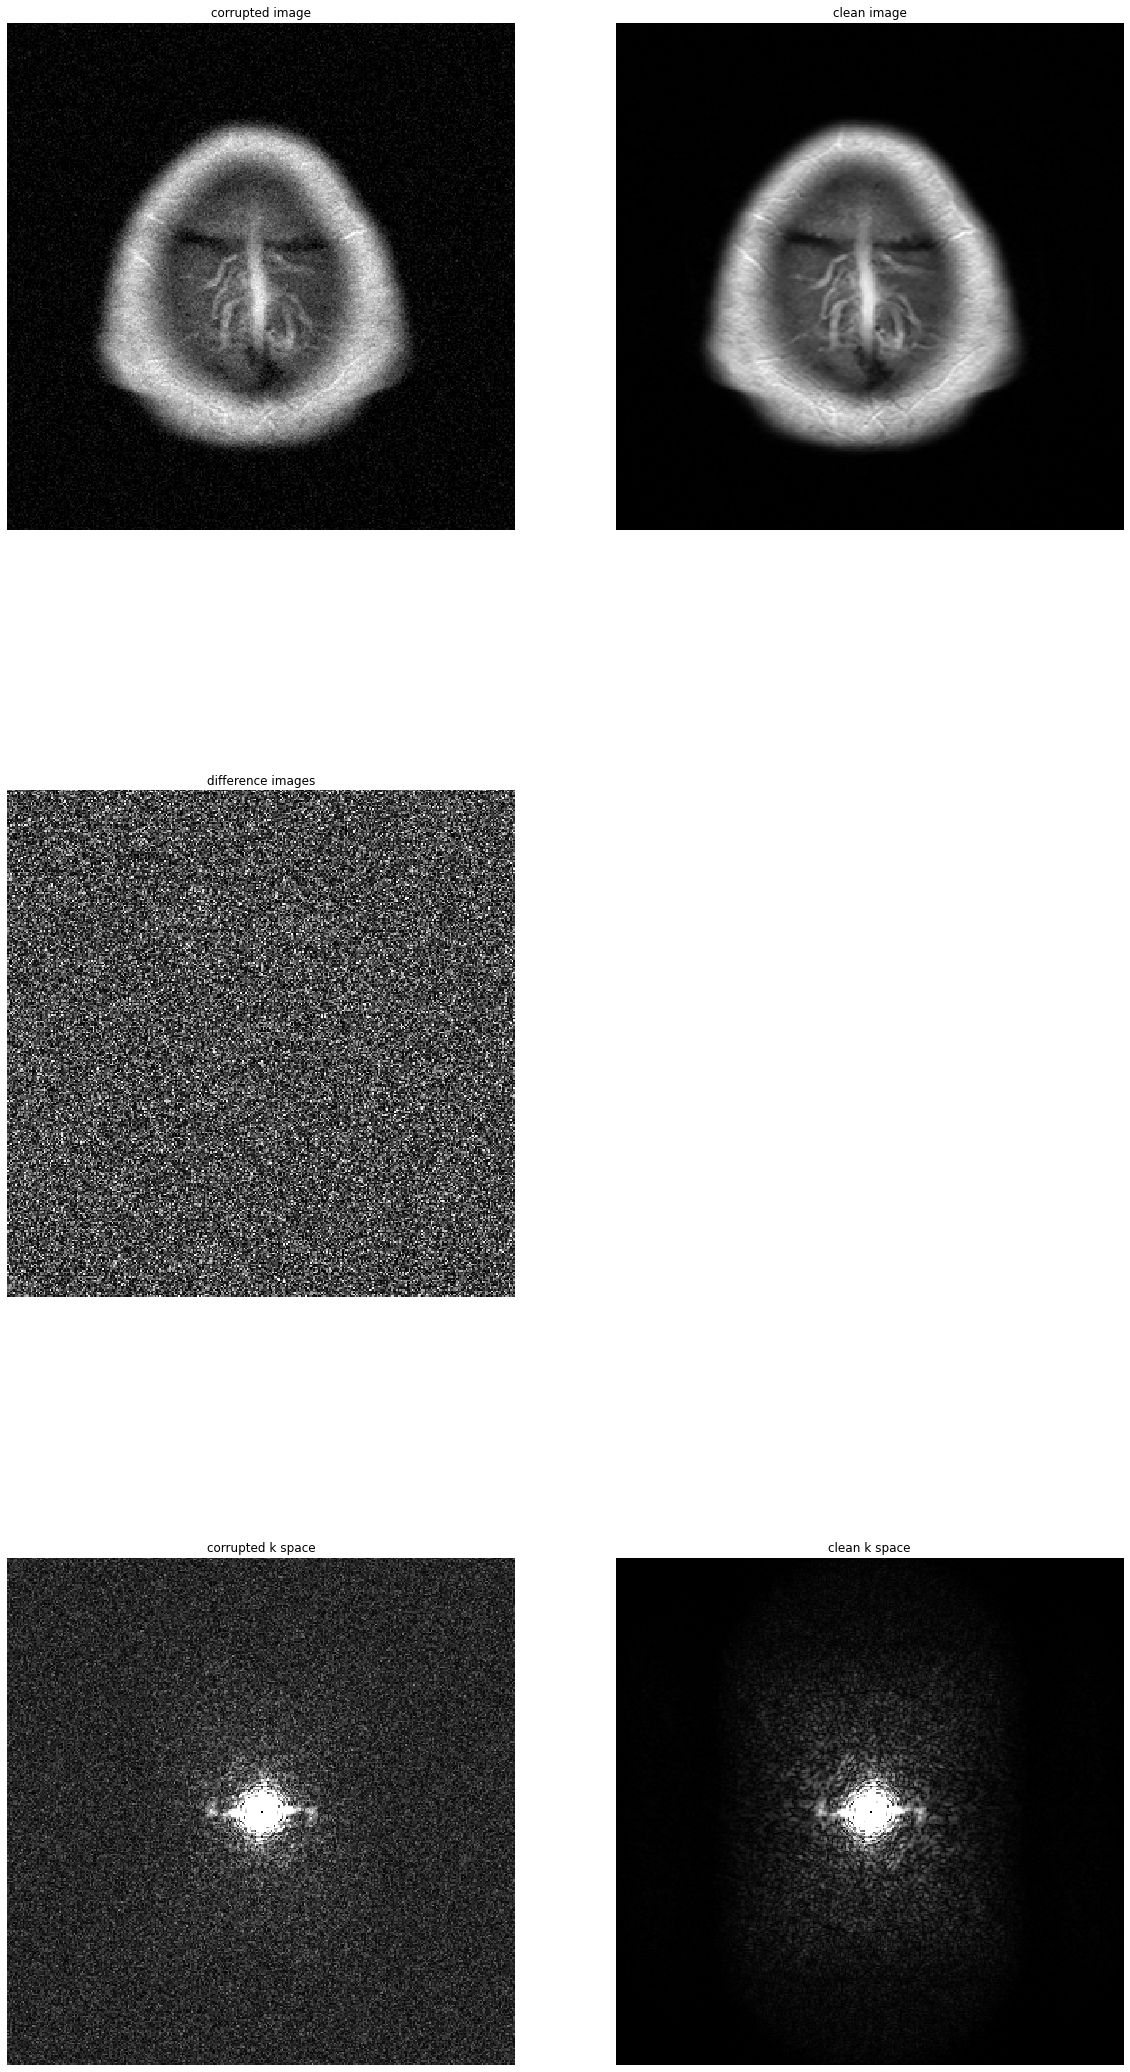

In [9]:
# plotting
hr = image
lr = img

k_lr = np.abs(transform_image_to_kspace(lr))
k_hr = np.abs(transform_image_to_kspace(hr))

k_lr = k_lr / np.max(np.abs(k_lr))
k_hr = k_hr / np.max(np.abs(k_hr))

lr = (lr - np.mean(lr)) / np.std(lr)
hr = (hr - np.mean(hr)) / np.std(hr)

vmx = np.max(hr)
vmn = np.min(hr)
dmx = 0.5
kmx = 0.01

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(3, 2, 1)
ax.imshow(lr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("corrupted image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 2)
ax.imshow(hr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("clean image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 3)
ax.imshow(np.abs(lr - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.set_title("difference images")
ax.axis('off')
ax = fig.add_subplot(3, 2, 5)
ax.imshow(k_lr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("corrupted k space")
ax.axis('off')
ax = fig.add_subplot(3, 2, 6)
ax.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("clean k space")
ax.axis('off')